# $sin(x)$

This notebook shows how you can use a Gaussian Process to estimate a noisy $sin(x)$ with limited data.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from gp import GaussianProcess
from gp.kernels import RBFKernel, WhiteNoiseKernel

In [3]:
def secret_function(x, noise=0.0):
    return torch.sin(x) + noise * torch.randn(x.shape)

In [4]:
def print_loss(gp):
    print("loss", gp.loss().detach().numpy())

In [5]:
def print_parameters(gp):
    for name, value in gp.named_parameters():
        print(name, value.detach().numpy())

In [6]:
def plot_variance(gp, x, y, title=None, std_factor=1.0):
    mu, std = gp(x, return_std=True)
    std *= std_factor
    
    mu = mu.detach().numpy()
    std = std.detach().numpy()
    
    x = x.numpy()
    y = y.detach().numpy()

    plt.figure(figsize=(12, 6))
    samples_plt, = plt.plot(
        X.numpy(), Y.numpy(),
        "bs", ms=4, label="Sampled points")
    y_plt, = plt.plot(x, y, "k--", label="Ground truth")
    mean_plt, = plt.plot(x, mu, "r", label="Estimate")
    std_plt = plt.gca().fill_between(
        x.flat, (mu - 3 * std).flat, (mu + 3 * std).flat,
        color="#dddddd", label="Three standard deviations")
    plt.axis([-4, 4, -2, 2])
    plt.title("Gaussian Process Estimate" if title is None else title)
    plt.legend(handles=[samples_plt, y_plt, mean_plt, std_plt])
    plt.show()

We sample 10 points at random 4 times and push them through our *secret* function. We reuse the same points simply to show that the $sin(x)$ function is indeed noisy and that the Gaussian Process is robust against it.

In [7]:
# Training data.
X = 10 * torch.rand(10, 1) - 4
X = torch.tensor(sorted(torch.cat([X] * 4))).reshape(-1, 1)
Y = secret_function(X, noise=1e-1)

In [8]:
# Test data.
x = torch.linspace(-4, 4).reshape(-1, 1)
y = secret_function(x)

In [9]:
# Construct GP.
k = RBFKernel() + WhiteNoiseKernel()
gp = GaussianProcess(k)
gp.set_data(X, Y)

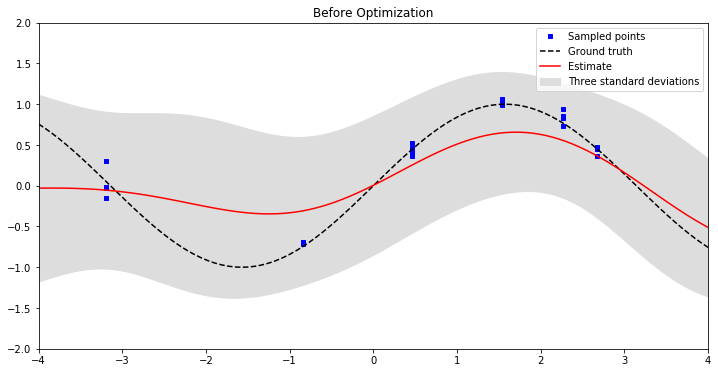

loss 42.361153
sigma_n [0.8583329]
kernel.first.length_scale [-1.1781826]
kernel.first.sigma_s [-0.43327796]
kernel.second.sigma_n [0.36878353]


In [10]:
plot_variance(gp, x, y, title="Before Optimization")
print_loss(gp)
print_parameters(gp)

In [11]:
gp.fit()

1000

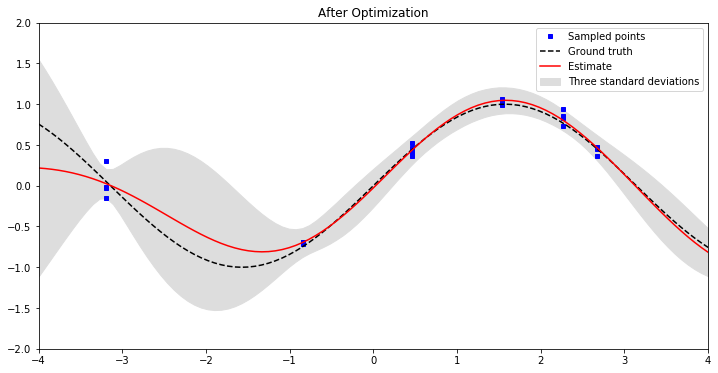

loss -9.994404
sigma_n [0.11853905]
kernel.first.length_scale [-1.4367721]
kernel.first.sigma_s [-0.91067874]
kernel.second.sigma_n [0.00162287]


In [12]:
plot_variance(gp, x, y, title="After Optimization")
print_loss(gp)
print_parameters(gp)